#                                    Сборный проект.

#  Цель : на  основе исторических данных о продажах игр, оценкок пользователей и экспертов, жанров и платформ выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

##  Отображение и изучение общей информации о данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns



In [2]:
project_full = pd.read_csv('/datasets/games.csv')
project_full.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
project_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


##  Предварительная обработка данных

In [4]:
project_full.columns = project_full.columns.str.lower()
project_full.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


Произведен переход на нижний регистр в названии столбцов

In [5]:
project_full['critic_score'] = project_full['critic_score'].astype('Int64')
project_full['year_of_release'] = project_full['year_of_release'].astype('Int64')
project_full['user_score'] = pd.to_numeric(project_full['user_score'] , errors='coerce')
project_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


Значения стобцов critic_score и year_of_release из дробных перведенны в целочисленный формат,
в обоих столбцах дробные - неприемлемо.  
Значения стобца user_score перведенны в дробный (десятибальная шкала оценки). 

In [6]:
project_full.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [7]:
project_full = project_full.dropna(subset=['name']).reset_index(drop=True)

Работа с пропусками. Столбец name удалены 2 пропуска - на дальнейшие результаты работы с датасэтом не влияет.

In [8]:
project_full = project_full.dropna(subset=['year_of_release']).reset_index(drop=True)

Присутствие пропусков в значениях столбца year_of_release связаны, возможно, 
с несколькими датами выхода игры на разных платформах. Иногда дат выхода несколько. Возможны и ошибки человеческого фактора. 
Строки необходимо удалить.


In [9]:
project_full['critic_score'] = project_full['critic_score'].fillna(0)
project_full['user_score'] = project_full['user_score'].fillna(0)

Значения в стобцах critic_score  и user_score  - это шкала оценок. Удаление строк неприемлемо,
ввиду высокого процента от общего кол-ва. Замена пропусков на ноль. 

In [10]:
project_full['rating'] = project_full['rating'].fillna('no_data')

Приравнять по аналогии  рейтинги каким-то образом и  заполнить этими значениями в пропусах - получим смещение от реаальности. 
Необходима замена значением, например no_data 

In [11]:
project_full.duplicated().sum()

0

Дубликатов нет

In [12]:
project_full['gen_sales'] = \
project_full['na_sales'] \
+ project_full['eu_sales'] \
+ project_full['jp_sales'] \
+ project_full['other_sales']
project_full.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,gen_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,no_data,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,no_data,31.38


In [13]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = project_full.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  Int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  gen_sales        16444 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

##  Исследовательский анализ данных

In [14]:
data_by_years = pd.pivot_table(project_full, index=['year_of_release'], values=['name'], aggfunc='count')
data_by_years = data_by_years.reset_index()
data_by_years.head()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14


## Анализ продаж за все периоды

Text(0, 0.5, 'Релизы')

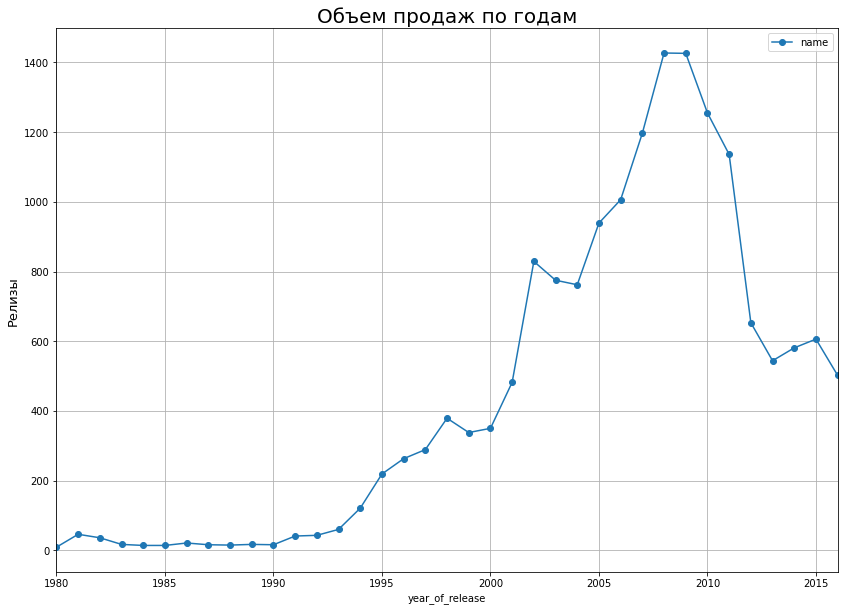

In [15]:
data_by_years.plot(x='year_of_release', y='name', style='o-', xlim=(1980, 2016),  grid=True, figsize=(14, 10))
plt.title('Объем продаж по годам', fontsize=20)
plt.ylabel('Релизы', fontsize=13)


Увеличение продаж более 200 копий было в 1995 году.
Общая тенденция увеличения мощностей и уменьшения стоимости комьютерного "железа" любой платформы правоцирует рост продаж с 2001 по 2015 с пиком в 2006-2008 году.
Икс бокс 360 и ПС3 - примерно в этих годах стали наиболее популярными.  

## Продажи по платформам. Платформы с наибольшими суммарными продажами и  распределение по годам.  Циклы жизни платформ
   

Text(0.5, 0, 'Год')

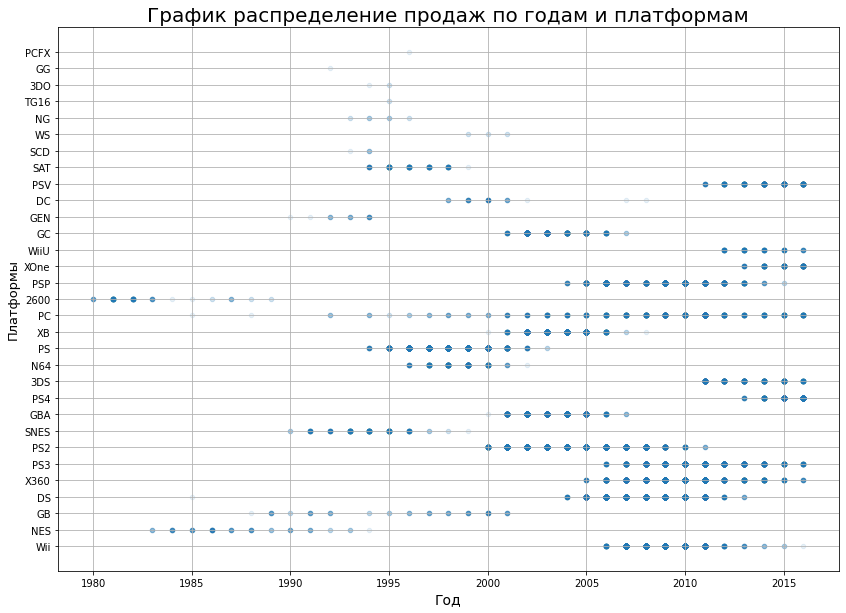

In [16]:
project_full.plot(x='year_of_release', y='platform', kind='scatter', alpha=0.1, grid=True, figsize=(14, 10))
plt.title('График распределение продаж по годам и платформам', fontsize=20)
plt.ylabel('Платформы', fontsize=13)
plt.xlabel('Год', fontsize=14)

График показывает, как менялся объем продаж, и протекали циклы существования платформ. 1995-2000 цикл PS. 
Доминировали SNES  и XBox в 2000-2005. 2005-2010 лучшие годы для DS,X360,ps3,(ps2-завершение),PSP.
с 2010 года "играли" в ps3,X360,psp. 
PC - стабильно был популярен с 2000г.
Остальные платформы более нишевые. с разными показателями, но так же с "циклами жизни"

Text(0, 0.5, 'Общие продажи копий млн.$')

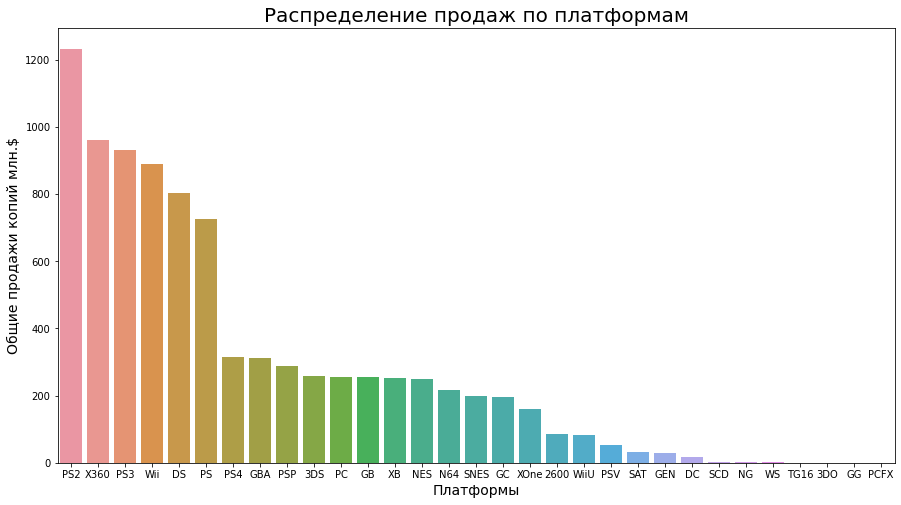

In [17]:
gen_world_sales = pd.pivot_table(project_full, index=['platform'],
                                      values=['gen_sales'],
                                      aggfunc='sum').sort_values(by='gen_sales', ascending=False)
gen_world_sales = gen_world_sales.reset_index()

plt.figure(figsize=(15,8))
sns.barplot(x=gen_world_sales['platform'],y=gen_world_sales['gen_sales'])
plt.title('Распределение продаж по платформам', fontsize=20)
plt.xlabel('Платформы', fontsize=14)
plt.ylabel('Общие продажи копий млн.$', fontsize=14)


Text(0, 0.5, 'Релизы')

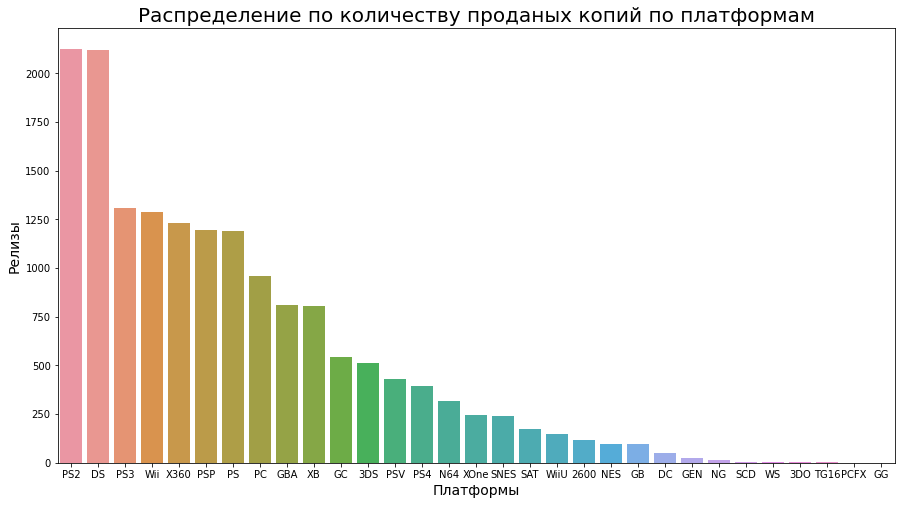

In [18]:
plaforms_quantity = pd.pivot_table(project_full, index=['platform'],
                                values=['name'],
                                aggfunc='count').sort_values(by='name', ascending=False)
plaforms_quantity = plaforms_quantity.reset_index()


plt.figure(figsize=(15,8))
sns.barplot(x=plaforms_quantity['platform'],y=plaforms_quantity['name'])
plt.title('Распределение по количеству проданых копий по платформам', fontsize=20)
plt.xlabel('Платформы', fontsize=14)
plt.ylabel('Релизы', fontsize=14)
           

PS2 и DC была лидером по кол-ву реализованных копий. Данные в шт.


In [19]:
quantity_2000_2017=project_full.query('2000 <= year_of_release <= 2017')

leaders = quantity_2000_2017.pivot_table(index=['platform'],
                                                  values=['gen_sales'],
                                                  aggfunc='sum').sort_values(by='gen_sales', ascending=False)

leaders = leaders.reset_index()

leaders.head(10)

,platform,gen_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.76
5,PS4,314.14
6,GBA,312.88
7,PSP,289.53
8,3DS,257.81
9,XB,251.57


В активный период 2000-2016 проанализируем 10 платформ с наиболее высокими продажами.

## Определение актуального периода. Работа с данными в срезе за 2013 по 2016 годы.

Text(0.5, 0, 'Год ')

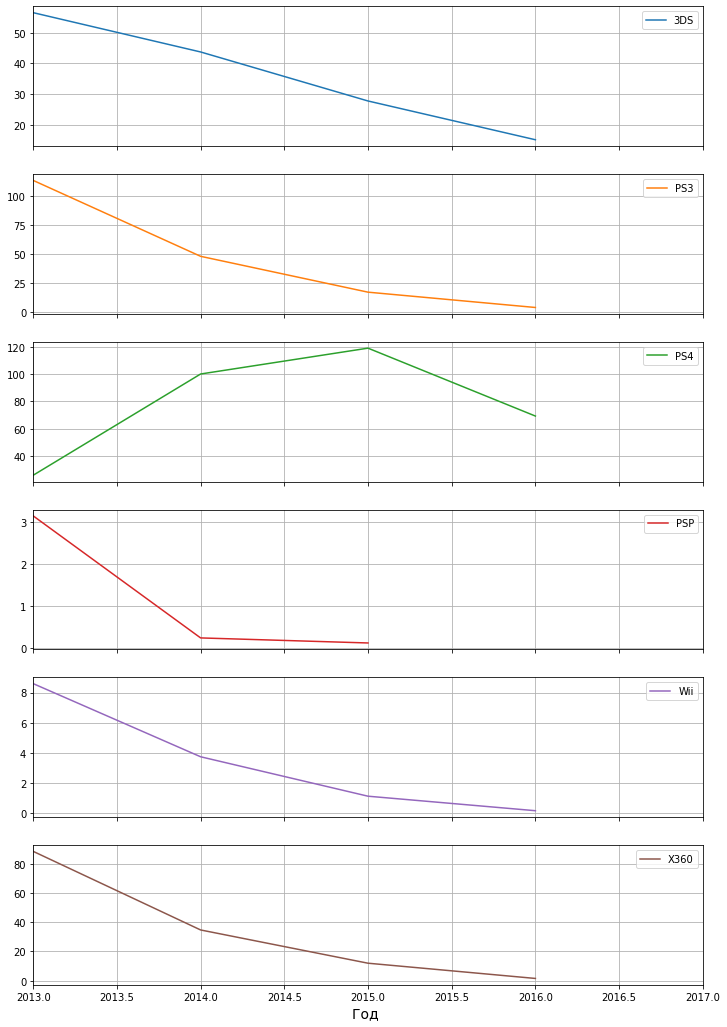

In [20]:
leaders_platforms_10 = ['Wii', 'X360', 'PS3', 'PS2', 'PS4', 'PSP', '3DS']
modern_platform_2013_2016 =project_full.query('2013 <= year_of_release <= 2016 & platform in @leaders_platforms_10')

sales_years_4 = modern_platform_2013_2016.pivot_table(index=['year_of_release'], columns=['platform'],
                                values=['gen_sales'], aggfunc='sum')
sales_years_4 = sales_years_4.reset_index()



sales_years_4.plot(x='year_of_release', y='gen_sales',
xlim=(2013, 2017), grid=True, figsize=(12, 18), subplots=True)
plt.xlabel('Год ', fontsize=14)



 <div class="alert alert-info">  На графике визуализирована тенденция к снижению продаж с 2013 по 2016 год.   </div>

##  Определение  потенциально прибыльных платформ.

In [21]:
select_2013_2016 = project_full.query('2013 <= year_of_release <= 2016')
top_platforms = select_2013_2016.pivot_table(index=['platform'],
                                                  values=['gen_sales'],
                                                  aggfunc='sum').sort_values(by='gen_sales', ascending=False)
top_platforms = top_platforms.reset_index()
top_platforms.head()

,platform,gen_sales
0,PS4,314.14
1,PS3,181.43
2,XOne,159.32
3,3DS,143.25
4,X360,136.80


## Визуализация распределения по глобальным продажам игр в разбивке по платформам.

In [22]:


select_2013_2016.groupby('platform')['gen_sales'].describe().sort_values(by='mean', ascending=False)


,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.200,0.7300,14.63
X360,186.0,0.735484,1.663275,0.01,0.0800,0.265,0.7950,16.27
XOne,247.0,0.645020,1.036139,0.01,0.0600,0.220,0.6850,7.39
Wii,23.0,0.593913,0.915432,0.01,0.0450,0.180,0.7550,3.58
WiiU,115.0,0.562000,1.038778,0.01,0.0600,0.200,0.5950,7.09
PS3,345.0,0.525884,1.451939,0.01,0.0400,0.150,0.5100,21.05
3DS,303.0,0.472772,1.381347,0.01,0.0400,0.090,0.2800,14.60
PC,189.0,0.208624,0.352304,0.01,0.0300,0.080,0.2300,3.05
DS,8.0,0.192500,0.172026,0.03,0.0675,0.150,0.2525,0.51


Text(0, 0.5, 'Общие продажи копий млн.$')

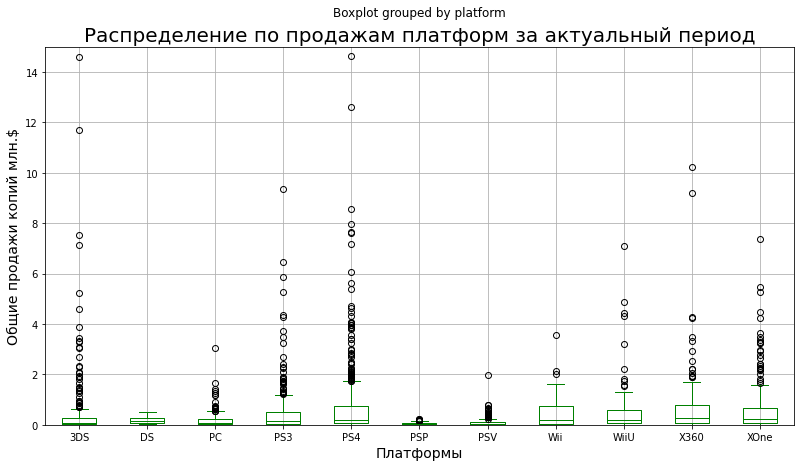

In [23]:


select_2013_2016.boxplot(by ='platform', column =['gen_sales'], grid = True, color='green', figsize=(13,7))
plt.ylim(0, 15)
plt.title('Распределение по продажам платформ за актуальный период', fontsize=20)
plt.xlabel('Платформы', fontsize=14, color='black')
plt.ylabel('Общие продажи копий млн.$', fontsize=14)

Text(0, 0.5, 'Общие продажи копий млн.$')

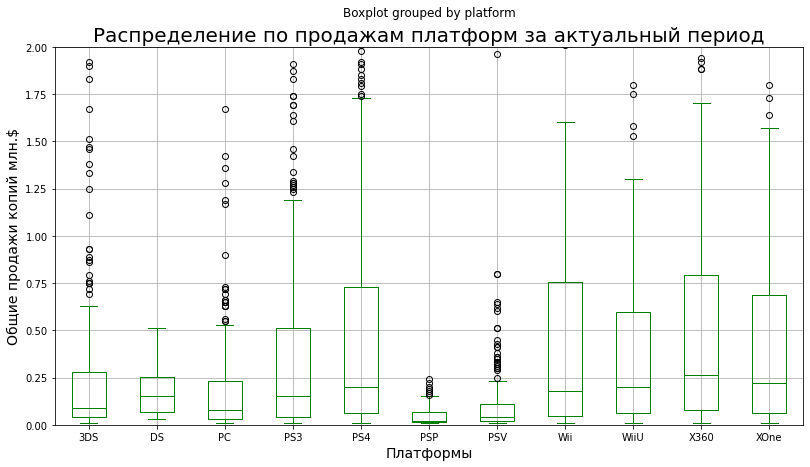

In [24]:
select_2013_2016.boxplot(by ='platform', column =['gen_sales'], grid = True, color='green', figsize=(13,7))
plt.ylim(0, 2)
plt.title('Распределение по продажам платформ за актуальный период', fontsize=20)
plt.xlabel('Платформы', fontsize=14, color='black')
plt.ylabel('Общие продажи копий млн.$', fontsize=14)

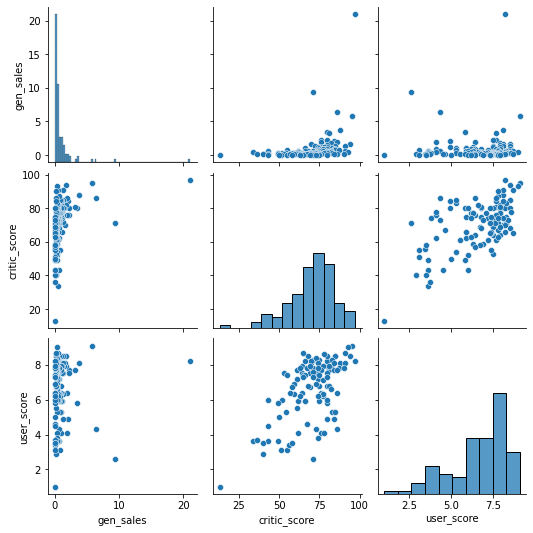

In [25]:
PS3_score = select_2013_2016.query('platform == "PS3" & critic_score != 0 & user_score != 0')


cols = ['gen_sales', 'critic_score', 'user_score']

sns_plot = sns.pairplot(PS3_score[cols])


## Влияния на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

Text(0.5, 1.0, 'График зависимости продаж PS3 от оценок критиков')

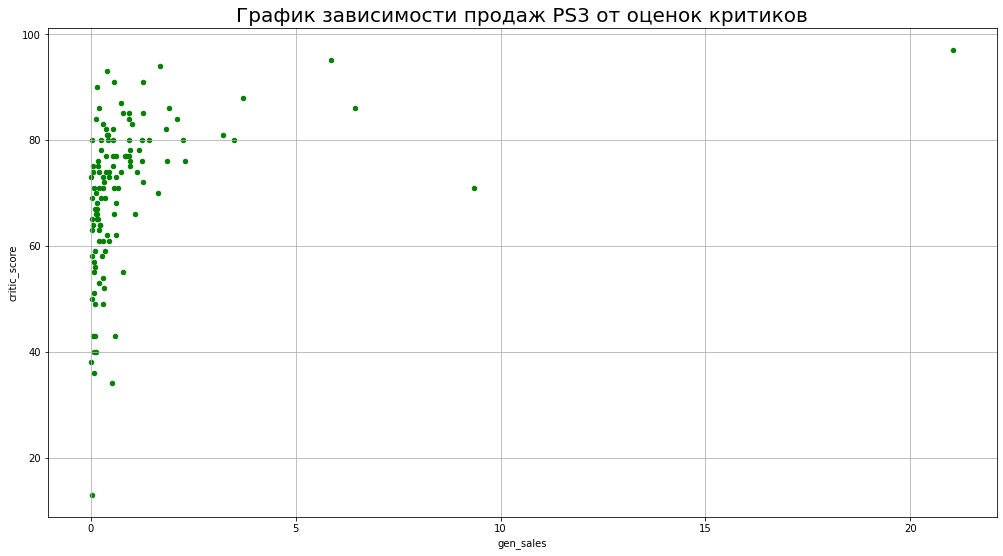

In [26]:
PS3_celan_c_score = select_2013_2016.query('platform == "PS3" & critic_score != 0')
PS3_celan_u_score = select_2013_2016.query('platform == "PS3" & user_score != 0')
PS3_celan_c_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PS3 от оценок критиков', fontsize=20)



Text(0.5, 1.0, 'График зависимости продаж PS3 от оценок пользователей')

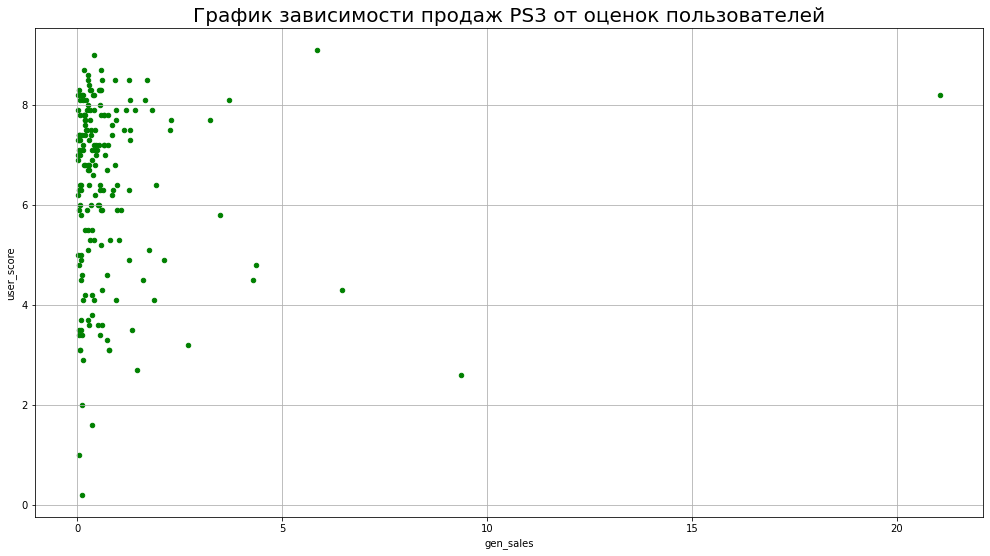

In [27]:
PS3_celan_u_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PS3 от оценок пользователей', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж PS3 от оценок критиков')

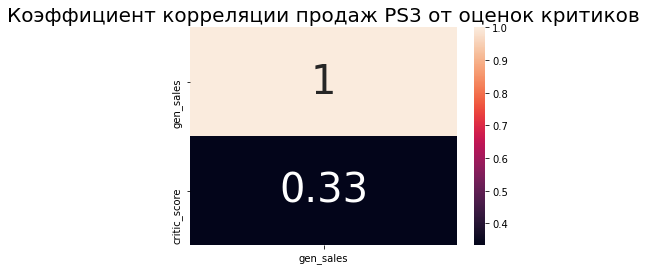

In [28]:
PS3_score_selected_c = PS3_celan_c_score[['gen_sales', 'critic_score',]]
sns.heatmap(PS3_score_selected_c.corr()[['gen_sales']], annot=True, annot_kws={'size':40})
plt.title('Коэффициент корреляции продаж PS3 от оценок критиков', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж PS3 от оценок пользователей')

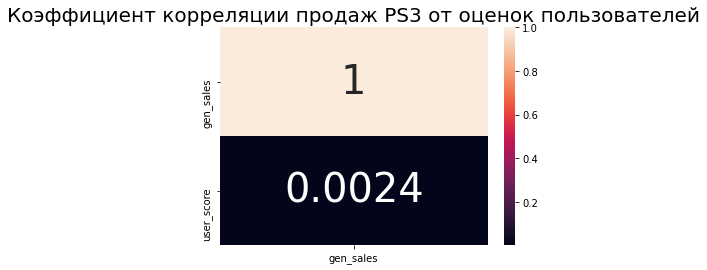

In [29]:
PS3_score_selected_u = PS3_celan_u_score[['gen_sales', 'user_score']]
sns.heatmap(PS3_score_selected_u.corr()[['gen_sales']], annot=True, annot_kws={'size':40})
plt.title('Коэффициент корреляции продаж PS3 от оценок пользователей', fontsize=20)



На примере PS3, как максимально успешной платформы выведен коэфициент корреляция между оценками пользователей, оценками критиков и общими продажами.

На world_sales и critic_score нули - это пропуски, ранее замененные. Продажи выше при высоких оценках .
Большая часть значений 30-100
На world_sales и user_score. Зависимость есть, она ниже. Есть не высокие оценки при достаточно высоком уровне продаж.    

Оценки играют на уровень продаж. Коэф. корреляции показан на heatmap. Зависимость не прямая.

Text(0.5, 1.0, 'График зависимости продаж X360 за 2013-2016 г. от оценок критиков')

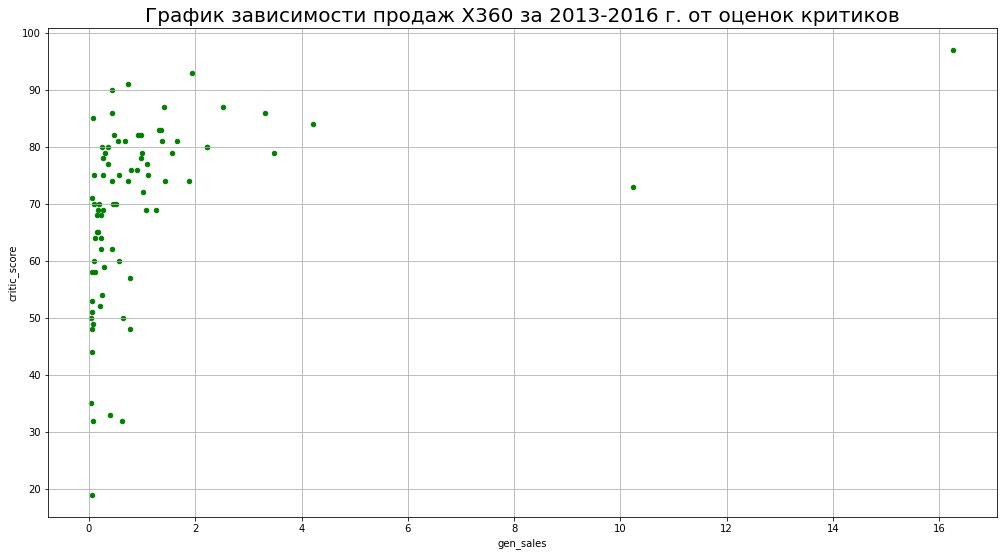

In [30]:
X360_critic_score = select_2013_2016.query('platform == "X360" & critic_score != 0')
X360_critic_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж X360 \
за 2013-2016 г. от оценок критиков', fontsize=20)
        

Text(0.5, 1.0, 'Коэффициент корреляции продаж X360 от оценок критиков')

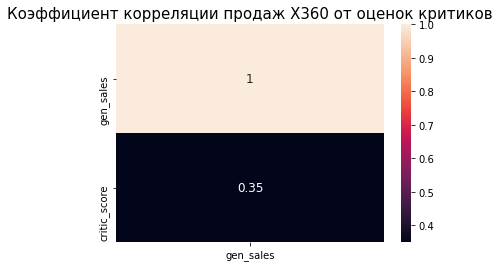

In [31]:
X360_critic_score = X360_critic_score[['gen_sales','critic_score']]
sns.heatmap(X360_critic_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж X360 от оценок критиков', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж X360 за 2013-2016 г. от оценок пользователей')

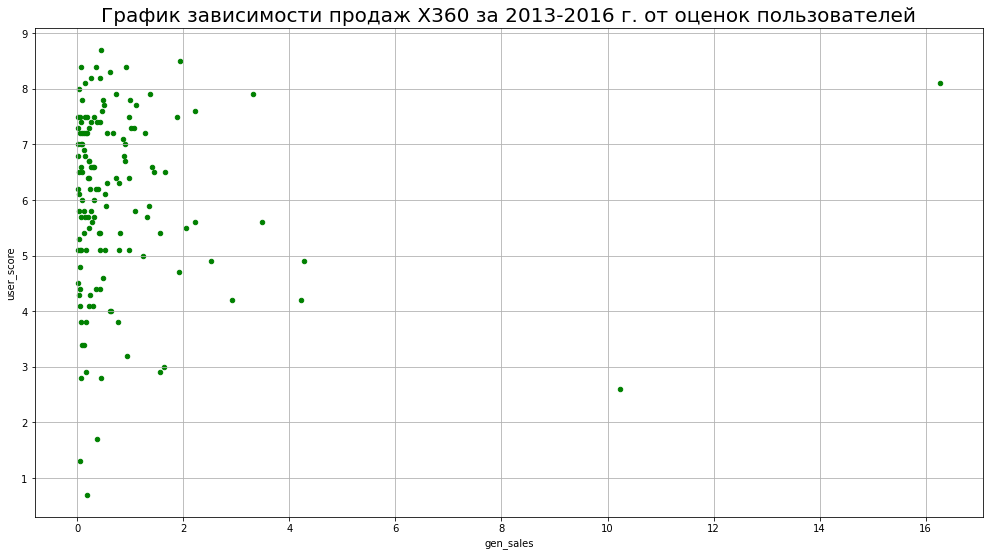

In [32]:
X360_user_score = select_2013_2016.query('platform == "X360" & user_score != 0')
X360_user_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж X360 \
за 2013-2016 г. от оценок пользователей', fontsize=20)


Text(0.5, 1.0, 'Коэффициент корреляции продаж X360 за 2013-2016 г. от оценок пользователей')

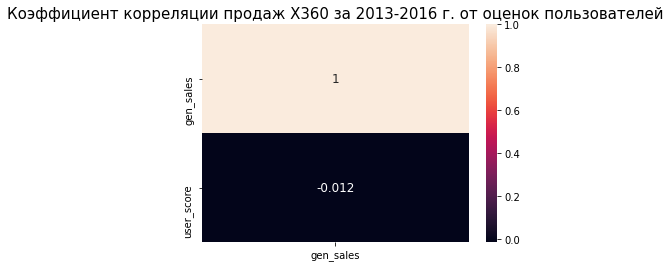

In [33]:
X360_user_score = X360_user_score[['gen_sales','user_score']]
sns.heatmap(X360_user_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж X360 за \
2013-2016 г. от оценок пользователей', fontsize=15)
          

Text(0.5, 1.0, 'График зависимости продаж PS4 за 2013-2016 г. от оценок критиков')

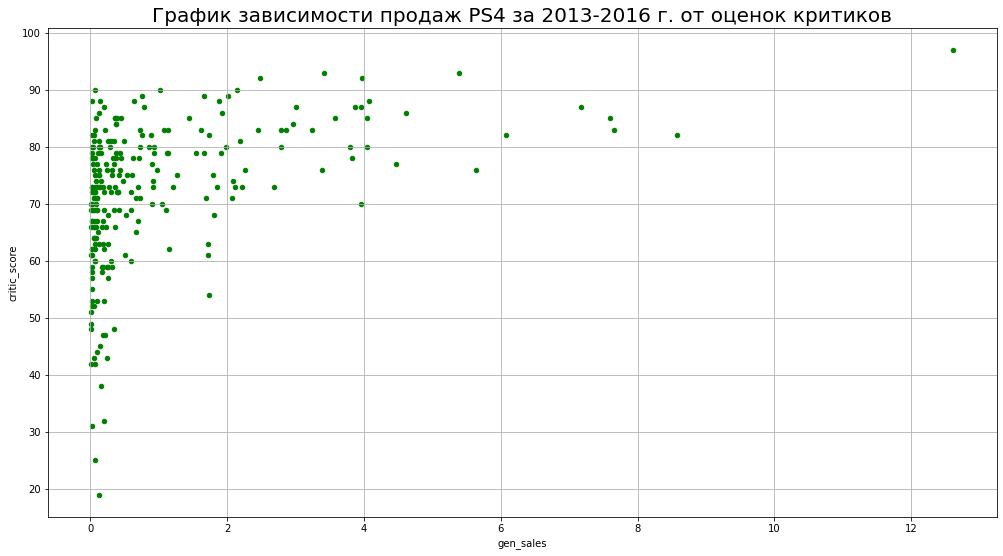

In [34]:
PS4_critic_score = select_2013_2016.query('platform == "PS4" & critic_score != 0')
PS4_critic_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PS4 \
за 2013-2016 г. от оценок критиков', fontsize=20)


Text(0.5, 1.0, 'Коэффициент корреляции продаж PS4 за 2013-2016 г. от оценок критиков')

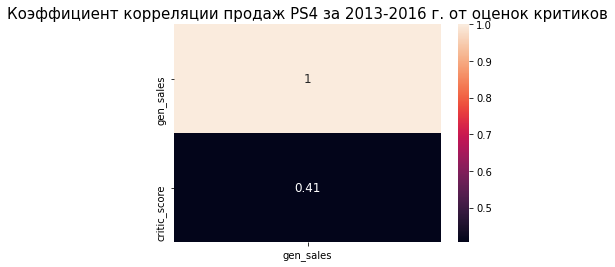

In [35]:
PS4_critic_score = PS4_critic_score[['gen_sales','critic_score']]
sns.heatmap(PS4_critic_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж PS4 за \
2013-2016 г. от оценок критиков', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж PS4 за 2013-2016 г. от оценок пользователей')

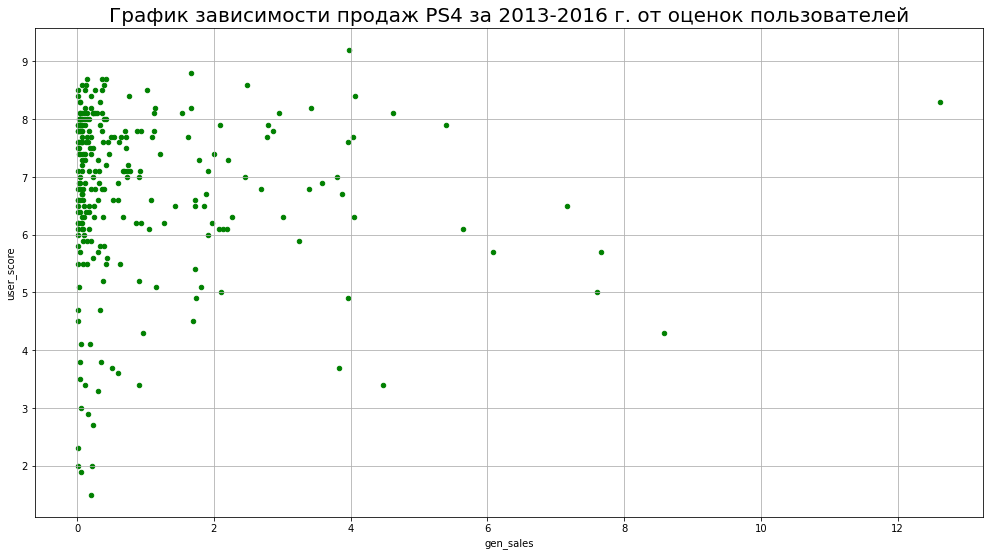

In [36]:
PS4_user_score = select_2013_2016.query('platform == "PS4" & user_score != 0')
PS4_user_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PS4 \
за 2013-2016 г. от оценок пользователей', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж PS4 за 2013-2016 г. от оценок пользователей')

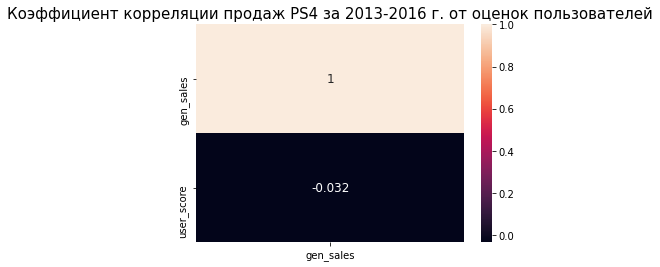

In [37]:
PS4_user_score = PS4_user_score[['gen_sales','user_score']]
sns.heatmap(PS4_user_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж PS4 за \
2013-2016 г. от оценок пользователей', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж XOne за 2013-2016 г. от оценок критиков')

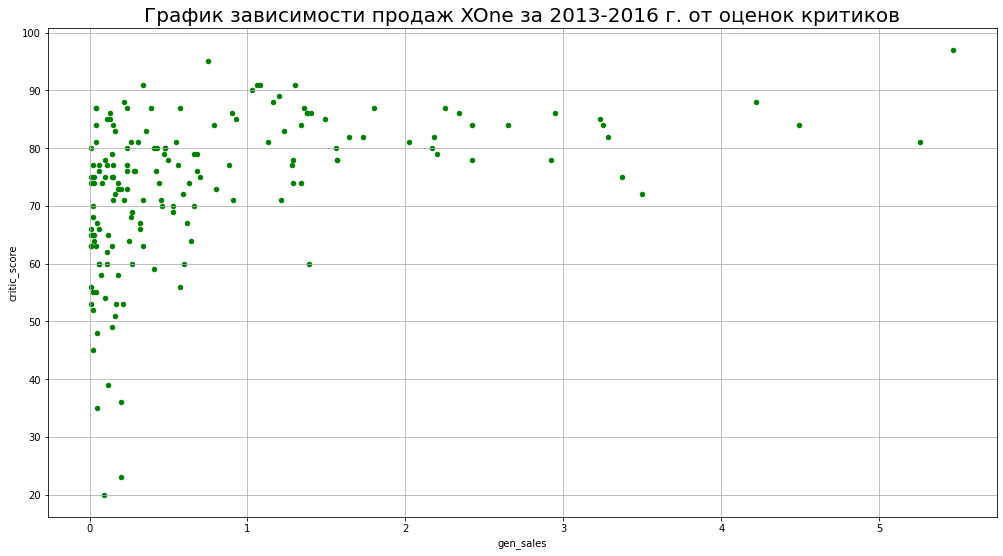

In [38]:
XOne_critic_score = select_2013_2016.query('platform == "XOne" & critic_score != 0')
XOne_critic_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж XOne \
за 2013-2016 г. от оценок критиков', fontsize=20)


Text(0.5, 1.0, 'Коэффициент корреляции продаж XOne за 2013-2016 г. от оценок критиков')

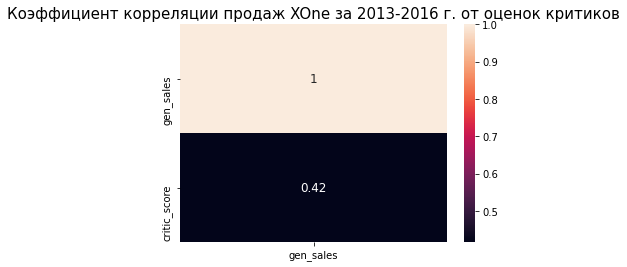

In [39]:
XOne_critic_score = XOne_critic_score[['gen_sales','critic_score']]
sns.heatmap(XOne_critic_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж XOne за \
2013-2016 г. от оценок критиков', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж XOne за 2013-2016 г. от оценок пользователей')

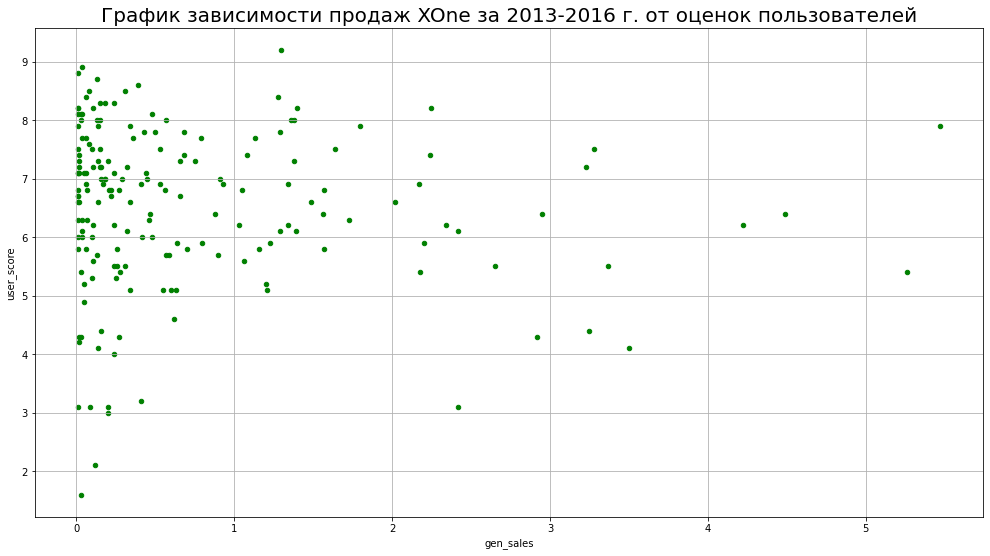

In [40]:
XOne_user_score = select_2013_2016.query('platform == "XOne" & user_score != 0')
XOne_user_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж XOne \
за 2013-2016 г. от оценок пользователей', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж XOne за 2013-2016 г. от оценок пользователей')

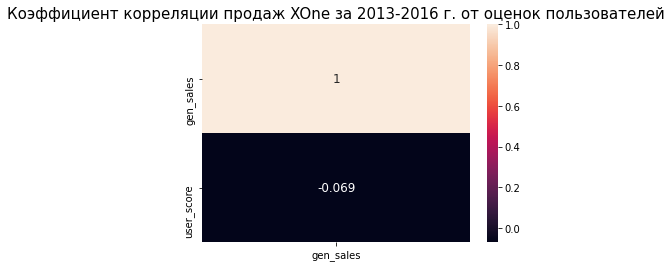

In [41]:
XOne_user_score = XOne_user_score[['gen_sales','user_score']]
sns.heatmap(XOne_user_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж XOne за \
2013-2016 г. от оценок пользователей', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж WiiU за 2013-2016 г. от оценок критиков')

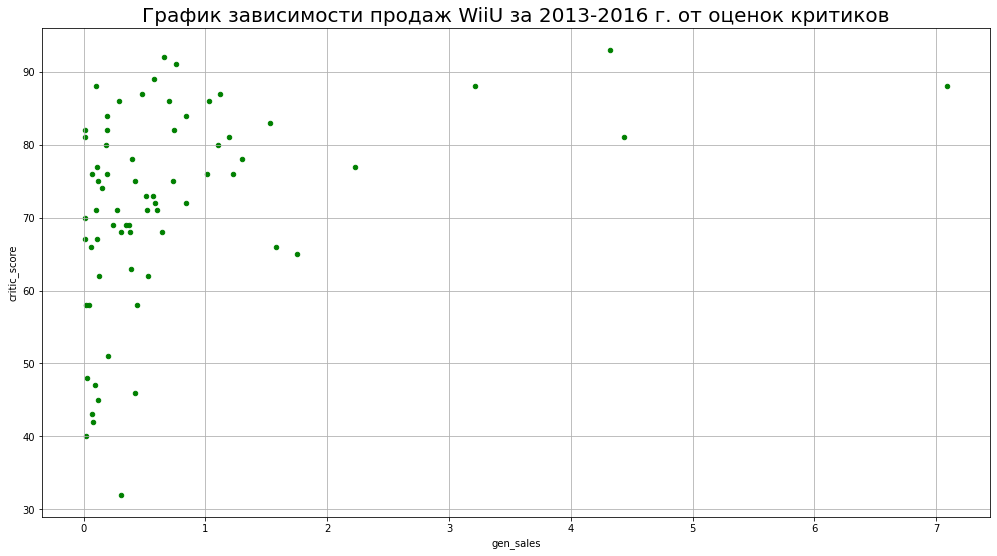

In [42]:
WiiU_critic_score = select_2013_2016.query('platform == "WiiU" & critic_score != 0')
WiiU_critic_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж WiiU \
за 2013-2016 г. от оценок критиков', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж WiiU за 2013-2016 г. от оценок критиков')

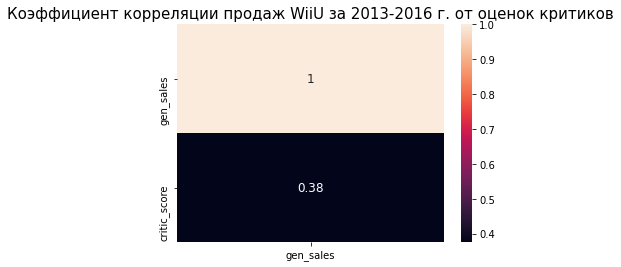

In [43]:
WiiU_critic_score = WiiU_critic_score[['gen_sales','critic_score']]
sns.heatmap(WiiU_critic_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж WiiU за \
2013-2016 г. от оценок критиков', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж WiiU за 2013-2016 г. от оценок пользователей')

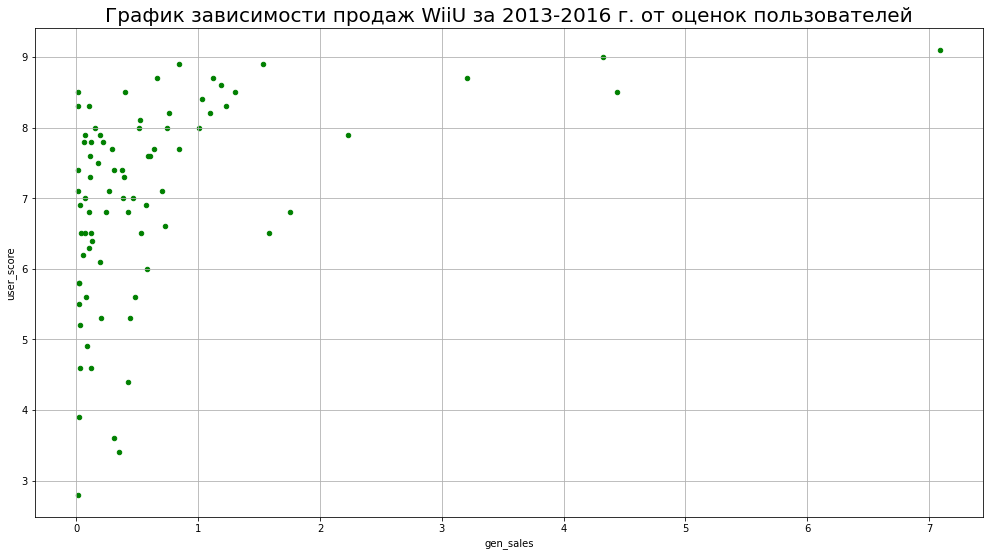

In [44]:
WiiU_user_score = select_2013_2016.query('platform == "WiiU" & user_score != 0')
WiiU_user_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж WiiU \
за 2013-2016 г. от оценок пользователей', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж WiiU за 2013-2016 г. от оценок пользователей')

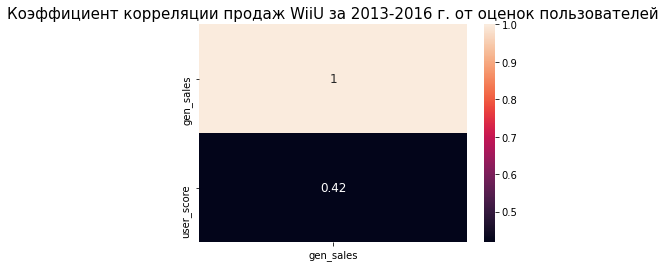

In [45]:
WiiU_user_score = WiiU_user_score[['gen_sales','user_score']]
sns.heatmap(WiiU_user_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж WiiU за \
2013-2016 г. от оценок пользователей', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж 3DS за 2013-2016 г. от оценок критиков')

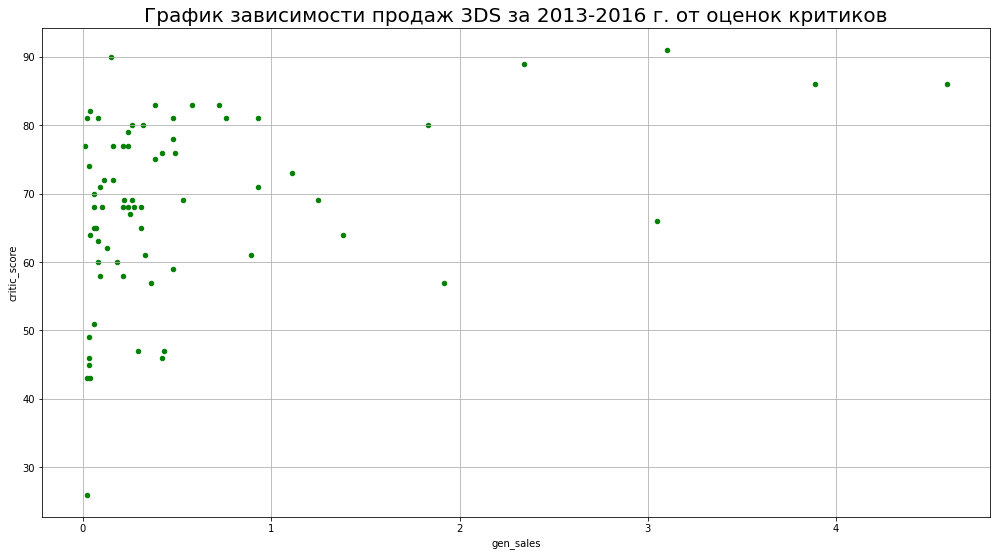

In [46]:
thrDS_critic_score = select_2013_2016.query('platform == "3DS" & critic_score != 0')
thrDS_critic_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж 3DS \
за 2013-2016 г. от оценок критиков', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж 3DS за 2013-2016 г. от оценок критиков')

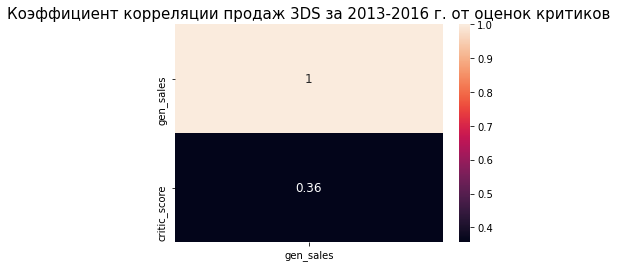

In [47]:
thrDS_critic_score = thrDS_critic_score[['gen_sales','critic_score']]
sns.heatmap(thrDS_critic_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж 3DS за \
2013-2016 г. от оценок критиков', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж 3DS за 2013-2016 г. от оценок пользователей')

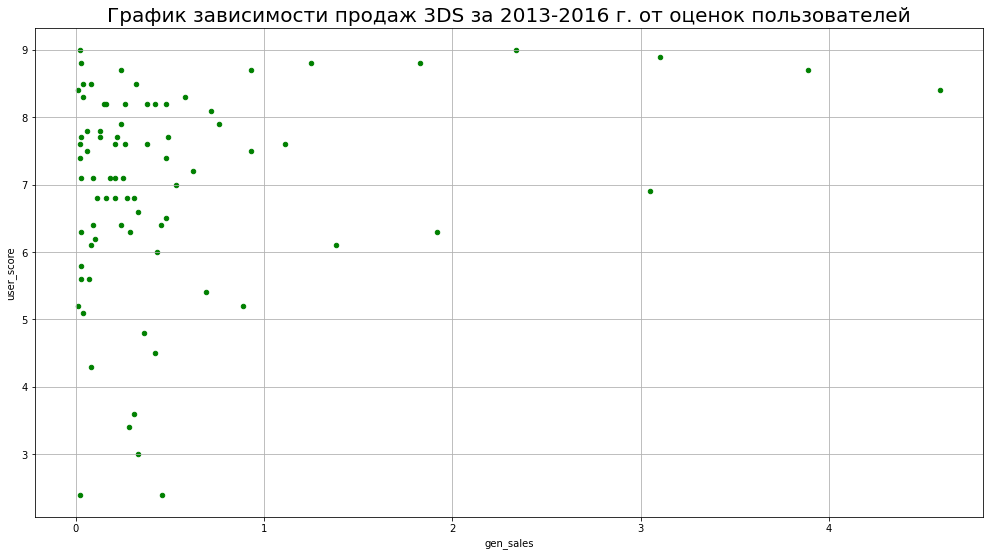

In [48]:
thrDS_user_score = select_2013_2016.query('platform == "3DS" & user_score != 0')
thrDS_user_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж 3DS \
за 2013-2016 г. от оценок пользователей', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж 3DS за 2013-2016 г. от оценок пользователей')

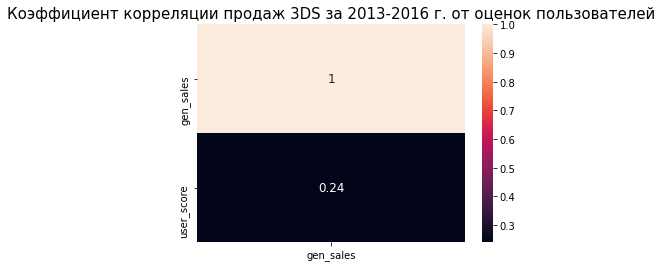

In [49]:
thrDS_user_score = thrDS_user_score[['gen_sales','user_score']]
sns.heatmap(thrDS_user_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж 3DS за \
2013-2016 г. от оценок пользователей', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж PC за 2013-2016 г. от оценок критиков')

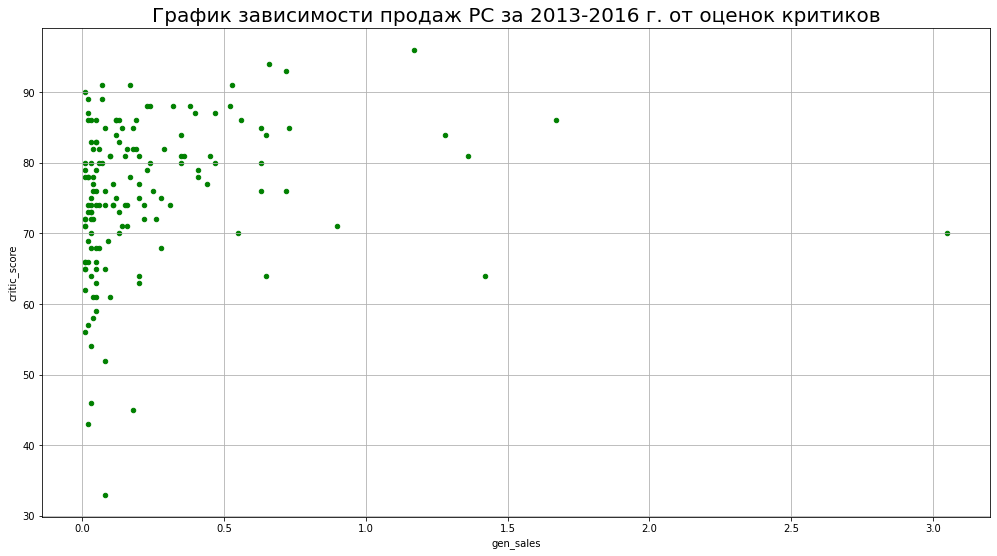

In [50]:
PC_critic_score = select_2013_2016.query('platform == "PC" & critic_score != 0')
PC_critic_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PC \
за 2013-2016 г. от оценок критиков', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж PC за 2013-2016 г. от оценок критиков')

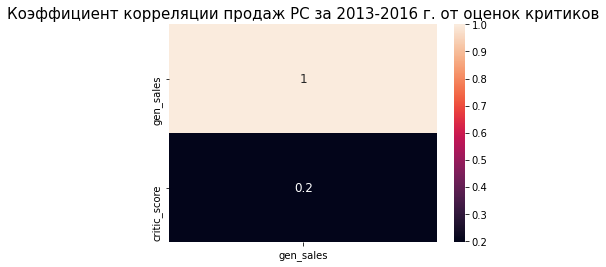

In [51]:
PC_critic_score = PC_critic_score[['gen_sales','critic_score']]
sns.heatmap(PC_critic_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж PC за \
2013-2016 г. от оценок критиков', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж PC за 2013-2016 г. от оценок пользователей')

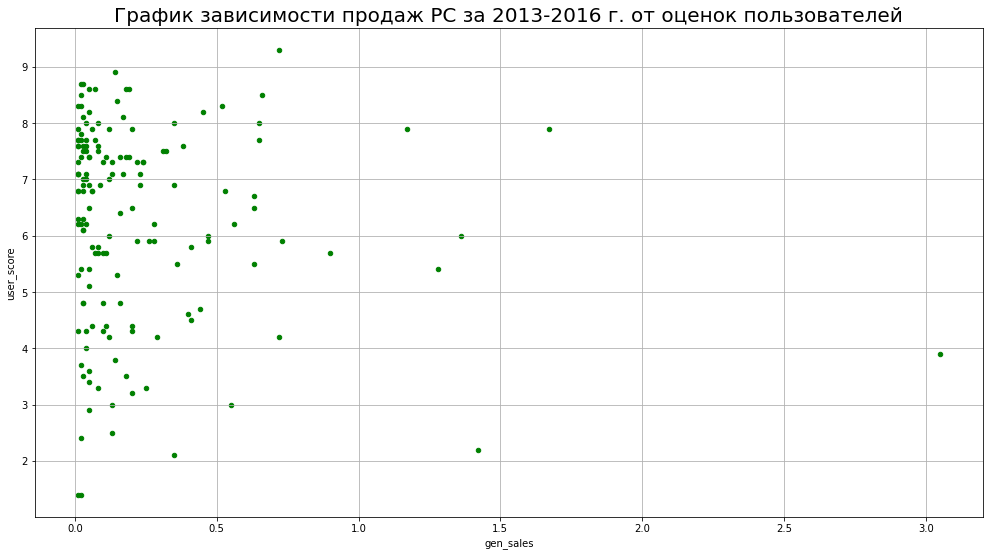

In [52]:
PC_user_score = select_2013_2016.query('platform == "PC" & user_score != 0')
PC_user_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PC \
за 2013-2016 г. от оценок пользователей', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж 3DS за 2013-2016 г. от оценок пользователей')

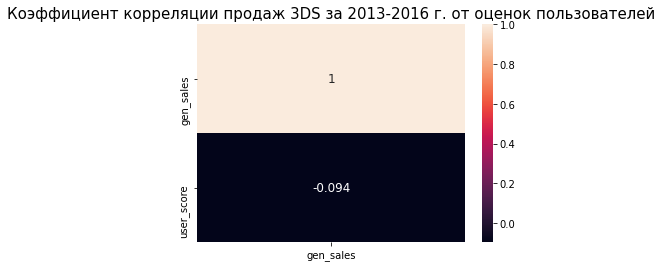

In [53]:
PC_user_score = PC_user_score[['gen_sales','user_score']]
sns.heatmap(PC_user_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж 3DS за \
2013-2016 г. от оценок пользователей', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж PSV за 2013-2016 г. от оценок критиков')

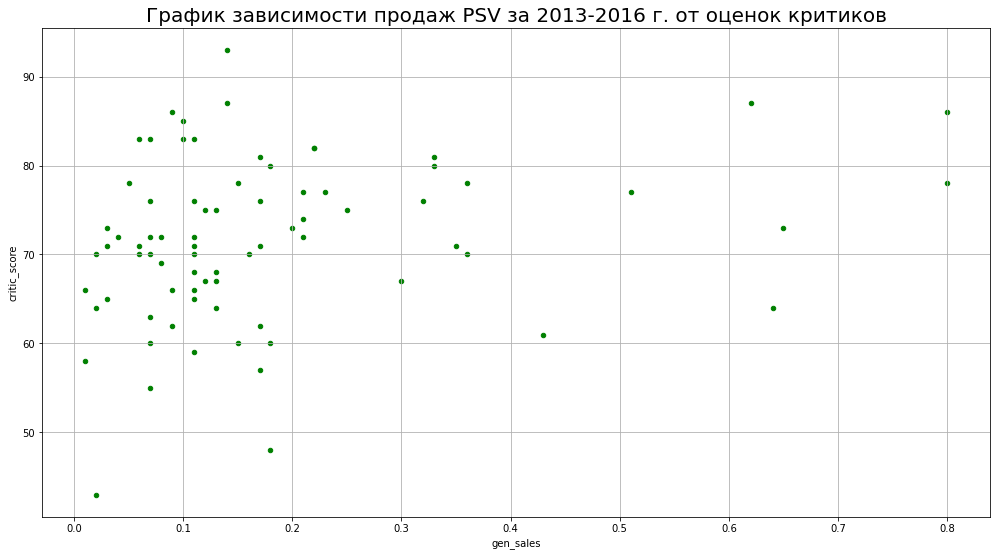

In [54]:
PSV_critic_score = select_2013_2016.query('platform == "PSV" & critic_score != 0')
PSV_critic_score.plot(x='gen_sales', 
                       y='critic_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PSV \
за 2013-2016 г. от оценок критиков', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж PSV за 2013-2016 г. от оценок критиков')

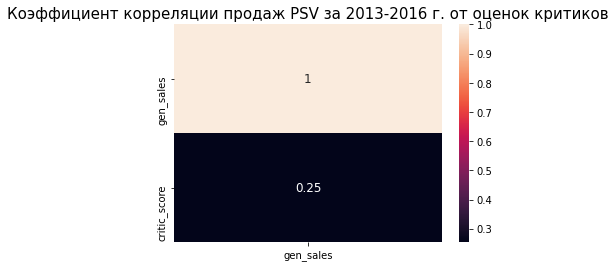

In [55]:
PSV_critic_score = PSV_critic_score[['gen_sales','critic_score']]
sns.heatmap(PSV_critic_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж PSV за \
2013-2016 г. от оценок критиков', fontsize=15)

Text(0.5, 1.0, 'График зависимости продаж PSV за 2013-2016 г. от оценок пользователей')

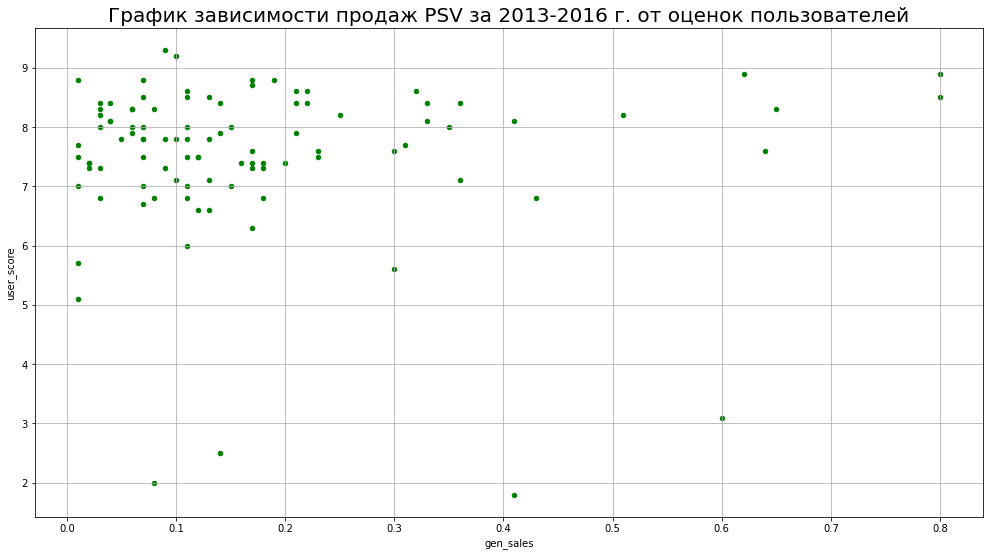

In [56]:
PSV_user_score = select_2013_2016.query('platform == "PSV" & user_score != 0')
PSV_user_score.plot(x='gen_sales', 
                       y='user_score',
                       kind='scatter', grid = True, color='green', 
                       figsize=(17,9))
plt.title('График зависимости продаж PSV \
за 2013-2016 г. от оценок пользователей', fontsize=20)

Text(0.5, 1.0, 'Коэффициент корреляции продаж PSV за 2013-2016 г. от оценок пользователей')

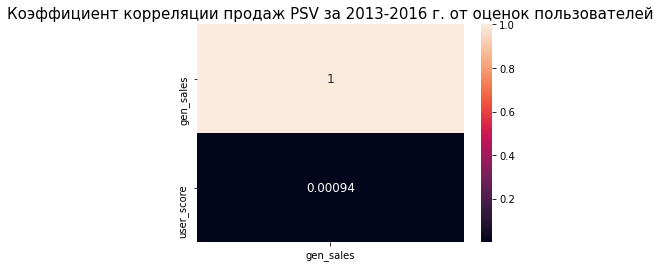

In [57]:
PSV_user_score = PSV_user_score[['gen_sales','user_score']]
sns.heatmap(PSV_user_score.corr()[['gen_sales']], annot=True, annot_kws={'size':12})
plt.title('Коэффициент корреляции продаж PSV за \
2013-2016 г. от оценок пользователей', fontsize=15)

Остальные платформы за период 2006-2016г. показывают более низкие медианные значения - в районе 0.1. 
Общие продажи в районе 6 млн. 3DS имеет больший диапазон разброса.
Xone имеет более высокую цену на свои тайтлы, относительно конкурентов, 
тенденция на удорожание продолжается до настоящего времени,
всвязи со сложностью разрабоки, поэтому расброс с более высших значений -1.8 млн. 

## Распределение игр по жанрам. Жанры с высокими и низкими продажами

In [58]:
genre_gen_sales = pd.pivot_table(select_2013_2016, index=['genre'],
                                   values=['gen_sales'],
                                   aggfunc='median').sort_values(by='gen_sales', ascending=False)
genre_gen_sales = genre_gen_sales.reset_index()

genre_gen_sales



,genre,gen_sales
0,Shooter,0.450
1,Sports,0.240
2,Platform,0.225
3,Role-Playing,0.125
4,Fighting,0.125
5,Racing,0.120
6,Action,0.110
7,Simulation,0.100
8,Misc,0.100
9,Strategy,0.080


Text(0.5, 1.0, 'Динамика продаж по жанрам')

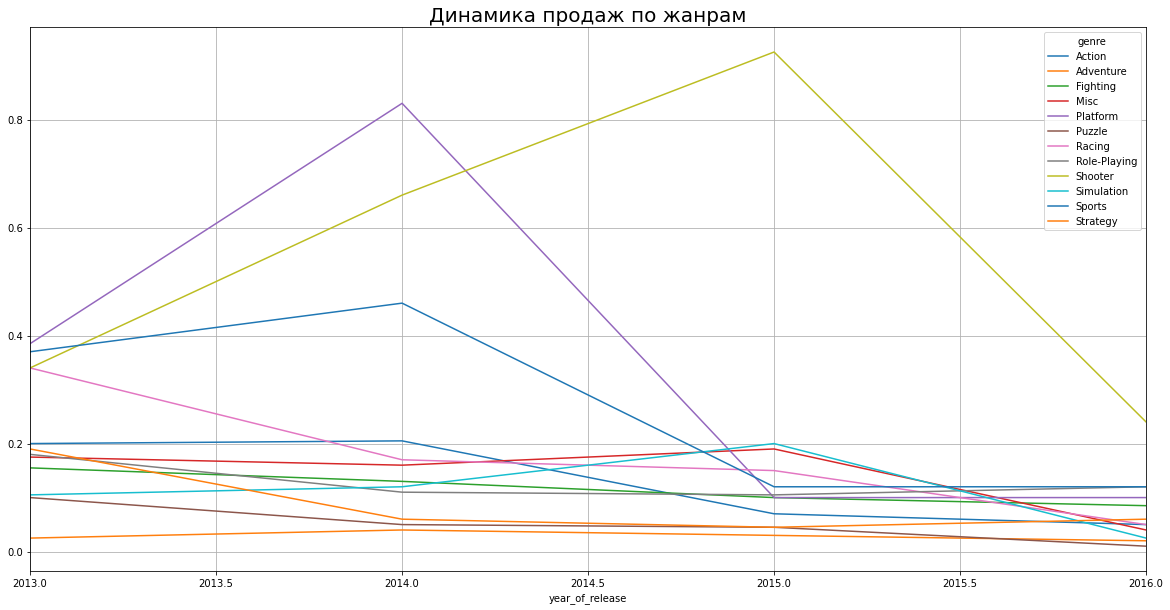

In [59]:
genre_sales_years = select_2013_2016.pivot_table(index=['year_of_release'], columns=['genre'],
                                values=['gen_sales'], aggfunc='median')
genre_sales_years = genre_sales_years.reset_index()
genre_sales_years.plot(x='year_of_release', y='gen_sales', xlim=(2013, 2016),  grid=True, figsize=(20, 10))
plt.title('Динамика продаж по жанрам', fontsize=20)

Text(0.5, 1.0, 'Динамика продаж по жанрам')

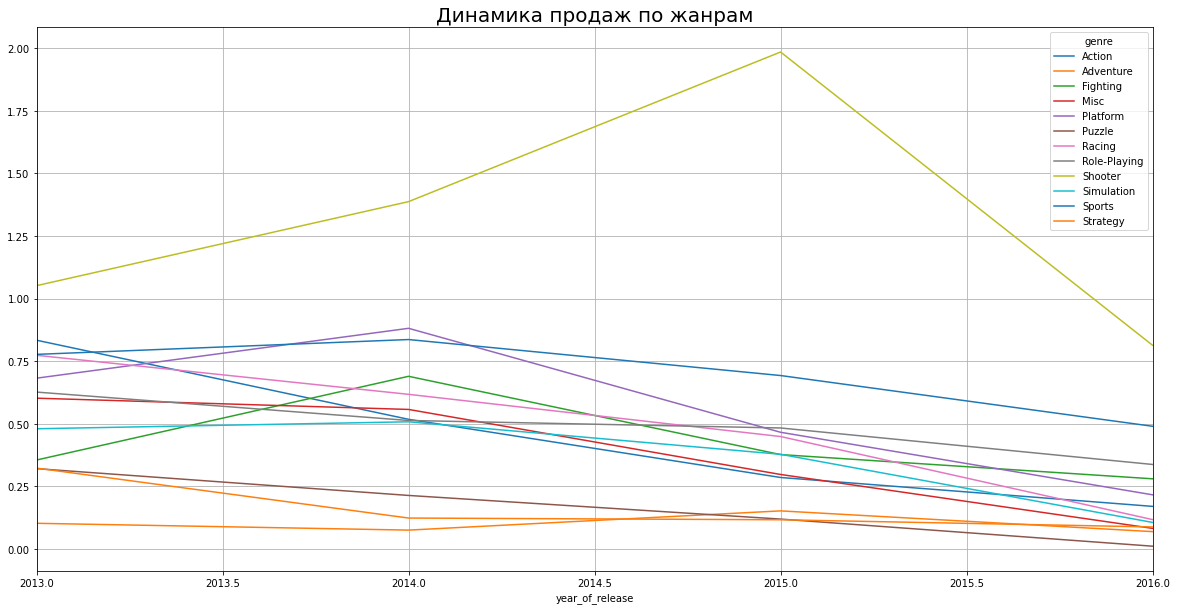

In [60]:
genre_sales_years = select_2013_2016.pivot_table(index=['year_of_release'], columns=['genre'],
                                values=['gen_sales'], aggfunc='mean')
genre_sales_years = genre_sales_years.reset_index()
genre_sales_years.plot(x='year_of_release', y='gen_sales', xlim=(2013, 2016),  grid=True, figsize=(20, 10))
plt.title('Динамика продаж по жанрам', fontsize=20)



Text(0.5, 1.0, 'Динамика продаж по жанрам')

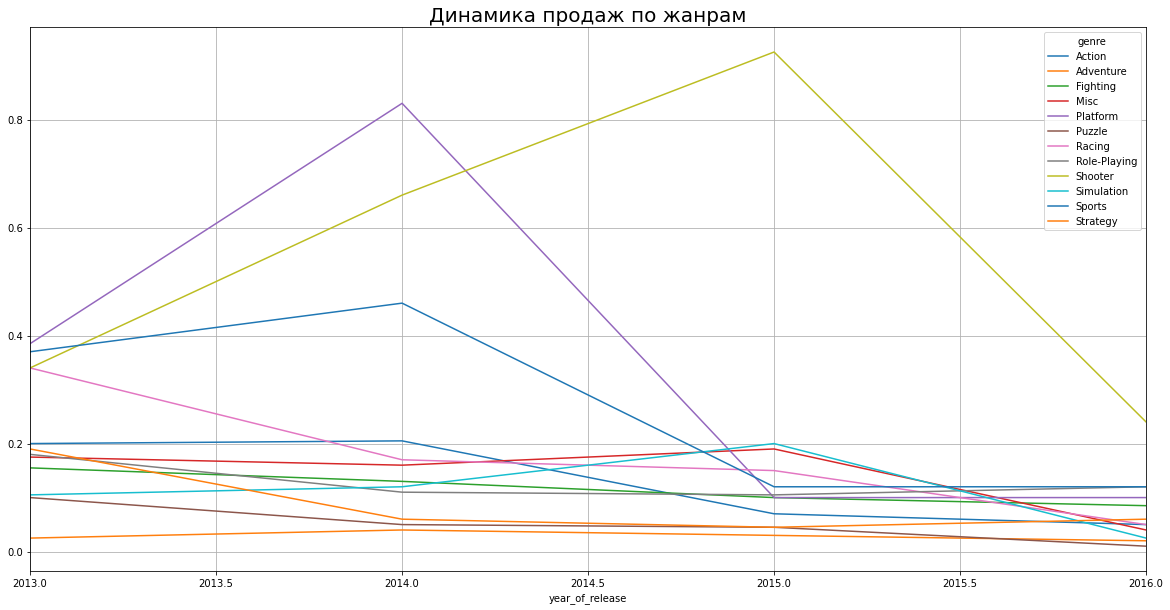

In [61]:
genre_sales_med = select_2013_2016.pivot_table(index=['year_of_release'], columns=['genre'],
                                values=['gen_sales'], aggfunc='median')
genre_sales_med = genre_sales_med.reset_index()
genre_sales_med.plot(x='year_of_release', y='gen_sales', xlim=(2013, 2016),  grid=True, figsize=(20, 10))
plt.title('Динамика продаж по жанрам', fontsize=20)

Динамика продаж по жанрам - количественные, средние и медианные значения показывают в разные периоды разную динамику.
Общая тенденция на уменьшение продаж к концу срока. 

##  Самые популярные платформы (топ-5). для каждого региона (NA, EU, JP)

,platform,na_sales
0,X360,0.15
1,XOne,0.12
2,WiiU,0.09
3,PS4,0.06
4,Wii,0.04


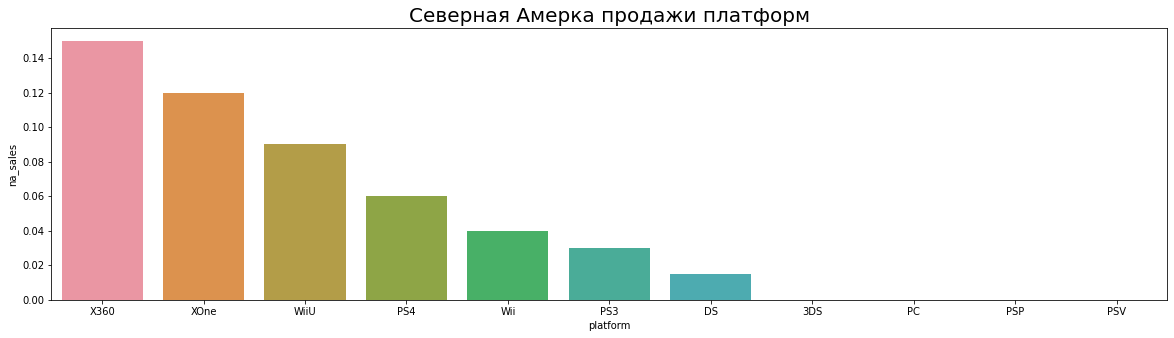

In [62]:
na_sales = select_2013_2016.pivot_table(index=['platform'],
                                                         values=['na_sales'], 
                                                         aggfunc='median').sort_values(by='na_sales', ascending=False)
na_sales = na_sales.reset_index()
plt.figure(figsize=(20,5))
sns.barplot(x=na_sales['platform'],y=na_sales['na_sales'])
plt.title('Северная Амерка продажи платформ',fontsize=20)

na_sales.head() 

,platform,eu_sales
0,Wii,0.100
1,DS,0.095
2,PS4,0.080
3,X360,0.080
4,WiiU,0.070


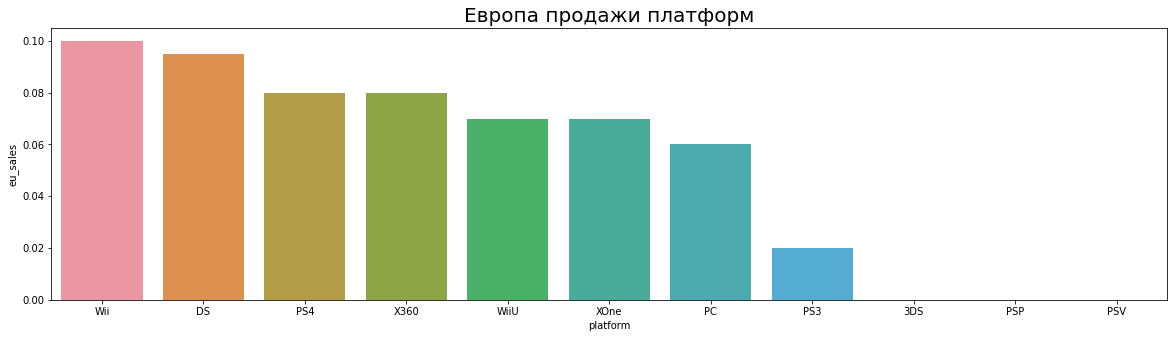

In [63]:
eu_sales = select_2013_2016.pivot_table(index=['platform'],
                                                         values=['eu_sales'], 
                                                         aggfunc='median').sort_values(by='eu_sales', ascending=False)
eu_sales = eu_sales.reset_index()
plt.figure(figsize=(20,5))
sns.barplot(x=eu_sales['platform'],y=eu_sales['eu_sales'])
plt.title('Европа продажи платформ',fontsize=20)

eu_sales.head() 

,platform,jp_sales
0,3DS,0.06
1,PS3,0.03
2,PSV,0.03
3,PSP,0.02
4,PS4,0.01


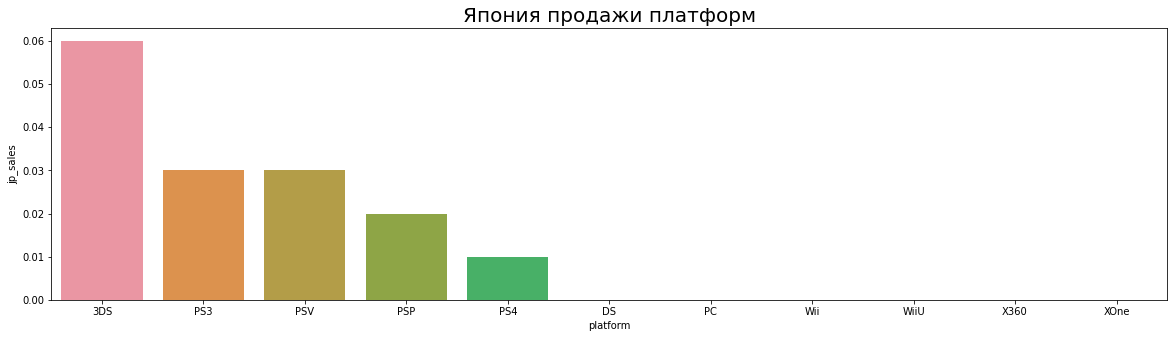

In [64]:
jp_sales = select_2013_2016.pivot_table(index=['platform'],
                                                         values=['jp_sales'], 
                                                         aggfunc='median').sort_values(by='jp_sales', ascending=False)
jp_sales = jp_sales.reset_index()
plt.figure(figsize=(20,5))
sns.barplot(x=jp_sales['platform'],y=jp_sales['jp_sales'])
plt.title('Япония продажи платформ',fontsize=20)

jp_sales.head() 

Лидером  в Северной Америке является X360, в Eвропе PS3, в Японии  - DS(Нинтендо). Платформа от Майкрософт
наиболее популярна в своей стране, таким же образом и японские производители.  В Европе с небольшим отрывом PS3 имела большую популярность.
Данные за 2006-2016г. 

## Самые популярные жанры (топ-5)

,genre,na_sales
0,Shooter,0.200
1,Platform,0.090
2,Sports,0.080
3,Fighting,0.045
4,Racing,0.030


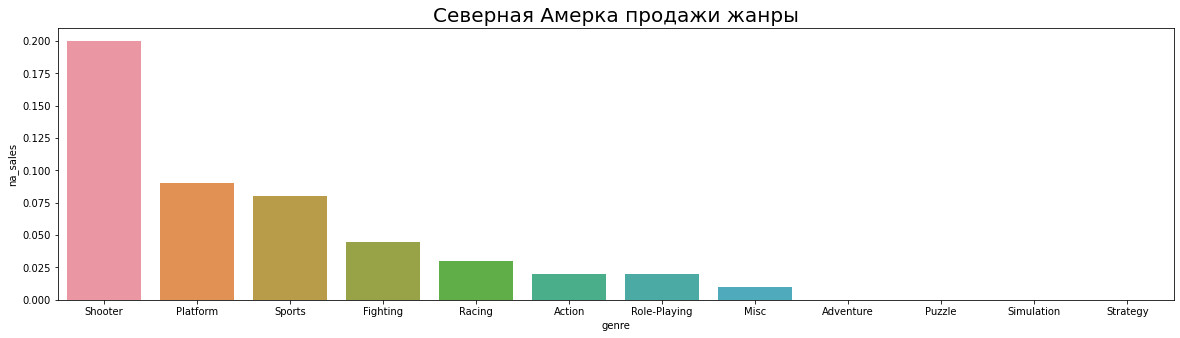

In [65]:
na_sales_genre = select_2013_2016.pivot_table(index=['genre'],
           values=['na_sales'], 
           aggfunc='median').sort_values(by='na_sales', ascending=False)
na_sales_genre = na_sales_genre.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=na_sales_genre['genre'],y=na_sales_genre['na_sales'])
plt.title('Северная Амерка продажи жанры',fontsize=20)

na_sales_genre.head() 

,genre,eu_sales
0,Shooter,0.190
1,Platform,0.080
2,Racing,0.060
3,Sports,0.050
4,Simulation,0.035


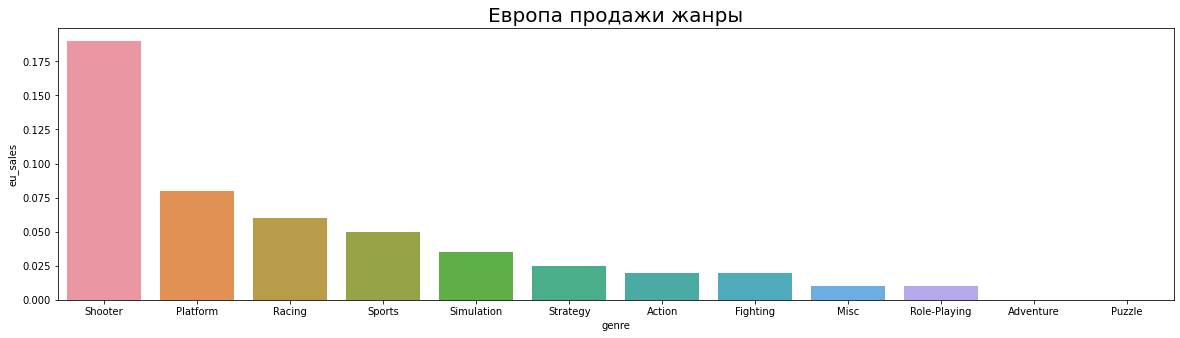

In [66]:
eu_sales_genre = select_2013_2016.pivot_table(index=['genre'],
           values=['eu_sales'], 
           aggfunc='median').sort_values(by='eu_sales', ascending=False)
eu_sales_genre = eu_sales_genre.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=eu_sales_genre['genre'],y=eu_sales_genre['eu_sales'])
plt.title('Европа продажи жанры',fontsize=20)

eu_sales_genre.head() 

,genre,jp_sales
0,Role-Playing,0.05
1,Fighting,0.03
2,Misc,0.02
3,Puzzle,0.02
4,Action,0.01


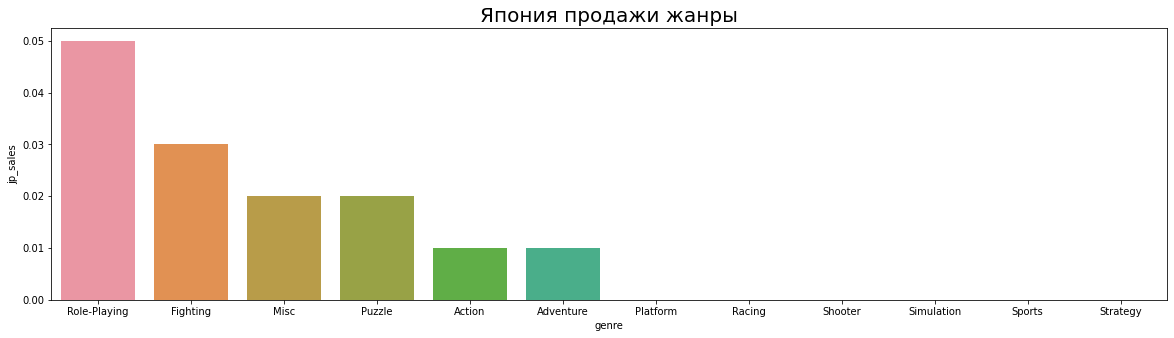

In [67]:
jp_sales_genre = select_2013_2016.pivot_table(index=['genre'],
           values=['jp_sales'], 
           aggfunc='median').sort_values(by='jp_sales', ascending=False)
jp_sales_genre = jp_sales_genre.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=jp_sales_genre['genre'],y=jp_sales_genre['jp_sales'])
plt.title('Япония продажи жанры',fontsize=20)

 
jp_sales_genre.head()


Role-Playing в Японии, Action и Sports - в Европе и Северной Америке самые популярные жанры в 
этом сегменте цифорвых развлечений за период 2006-2016г.
Азия имеет несколько другие всем известные различия, относительно других континентов, 
это сказываентся и на мир компьютерных игр.


## Влияние рейтинга ESRB на продажи в регионах

,rating,na_sales
0,M,0.14
1,E10+,0.12
2,E,0.05
3,T,0.04
4,no_data,0.00


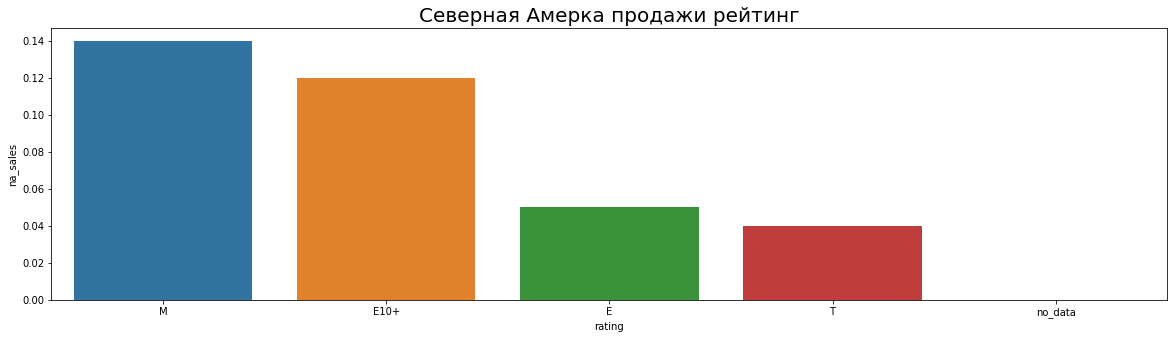

In [68]:
rating_na_sales = select_2013_2016.pivot_table(index=['rating'],
                                                         values=['na_sales'], 
                                                         aggfunc='median').sort_values(by='na_sales', ascending=False)
rating_na_sales = rating_na_sales.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=rating_na_sales['rating'], y=rating_na_sales['na_sales'])
plt.title('Северная Амерка продажи рейтинг',fontsize=20)

rating_na_sales.head()

,rating,eu_sales
0,M,0.130
1,E10+,0.100
2,E,0.055
3,T,0.040
4,no_data,0.000


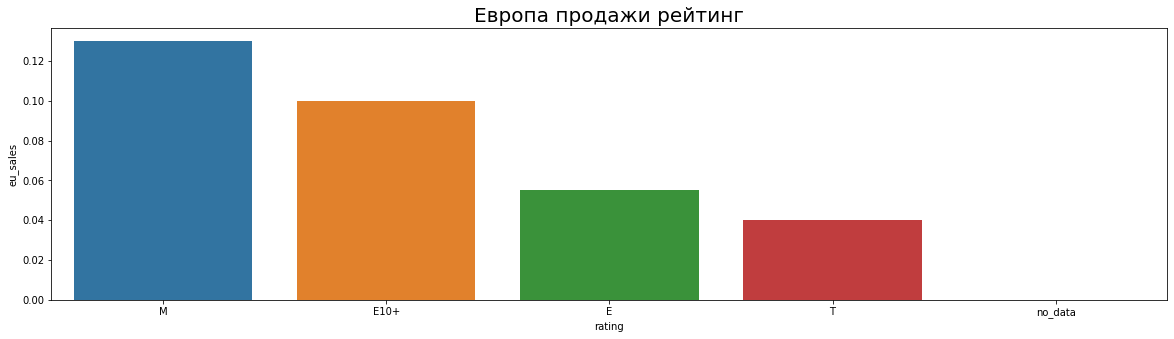

In [69]:
rating_eu_sales = select_2013_2016.pivot_table(index=['rating'],
                                                         values=['eu_sales'], 
                                                         aggfunc='median').sort_values(by='eu_sales', ascending=False)
rating_eu_sales = rating_eu_sales.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=rating_eu_sales['rating'], y=rating_eu_sales['eu_sales'])
plt.title('Европа продажи рейтинг',fontsize=20)

rating_eu_sales.head()

,rating,jp_sales
0,no_data,0.02
1,T,0.01
2,E,0.00
3,E10+,0.00
4,M,0.00


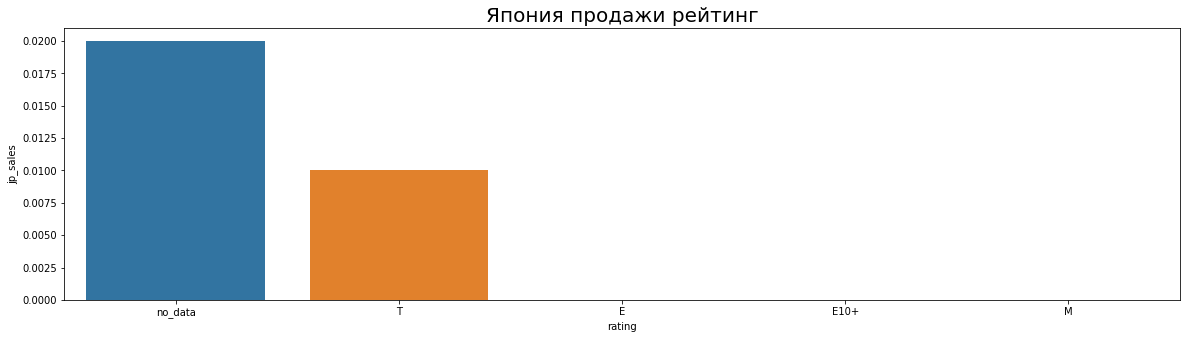

In [70]:
rating_jp_sales = select_2013_2016.pivot_table(index=['rating'],
                                                         values=['jp_sales'], 
                                                         aggfunc='median').sort_values(by='jp_sales', ascending=False)
rating_jp_sales = rating_jp_sales.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x=rating_jp_sales['rating'], y=rating_jp_sales['jp_sales'])
plt.title('Япония продажи рейтинг',fontsize=20)

rating_jp_sales.head()

## Проверка гипотез

Гипотеза 1
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

H_0: Средние пользовательские рейтинги (platform) "Xbox One" = рейтинги (platform) пользователей "PC"`

H_a: Средние пользовательские рейтинги (platform) "Xbox One" ≠ рейтинги (platform) пользователей "PC"`

alpha = 0.05




p-значение: 0.14760
Не получилось отвергнуть нулевую гипотезу


(0.0, 10.0)

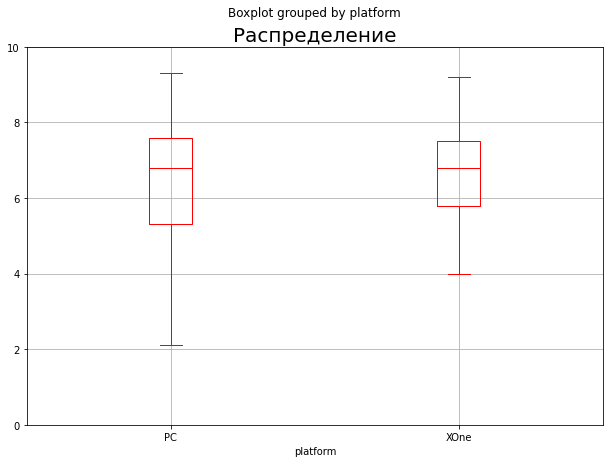

In [71]:
select_2013_2016 = select_2013_2016.query('user_score != 0')

x_platform = select_2013_2016[select_2013_2016['platform']=='XOne']

pc_platform = select_2013_2016[select_2013_2016['platform']=='PC']


results = st.ttest_ind(x_platform['user_score'], pc_platform['user_score'], equal_var = False)

alpha = 0.05

print('p-значение: {:.5f}'.format(results.pvalue))

if results.pvalue < alpha:  
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
  
Micr = select_2013_2016[select_2013_2016['platform'].isin(['XOne','PC'])] 



Micr.boxplot(by ='platform', column =['user_score'], grid = True, color='red', figsize=(10,7), showfliers=False)
plt.title('Распределение', fontsize=20)
plt.ylim(0, 10)


p-значение: 0.00000
Отвергаем нулевую гипотезу


(0.0, 10.0)

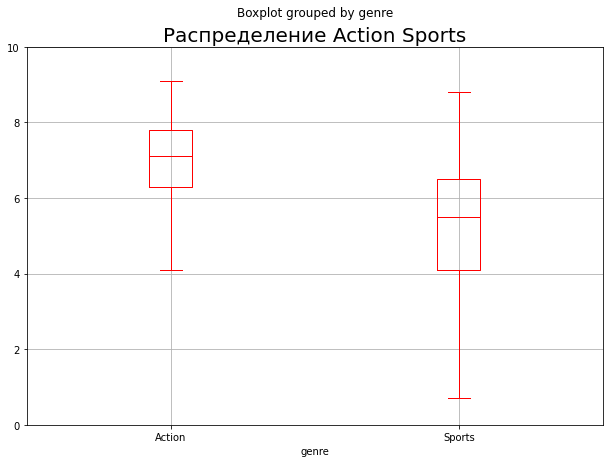

In [72]:
select_2013_2016 = select_2013_2016.query('user_score != 0')
action_genre = select_2013_2016[select_2013_2016['genre']=='Action']
sports_genre = select_2013_2016[select_2013_2016['genre']=='Sports']

results = st.ttest_ind(action_genre['user_score'], sports_genre['user_score'], equal_var = False)

alpha = 0.05

print('p-значение: {:.5f}'.format(results.pvalue))

if results.pvalue < alpha:  
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
Action_Sports = select_2013_2016[select_2013_2016['genre'].isin(['Action','Sports'])]    
Action_Sports.boxplot(by ='genre', column =['user_score'], grid = True, color='red', figsize=(10,7), showfliers=False)
plt.title('Распределение Action Sports', fontsize=20)
plt.ylim(0, 10)

Нулевая гипотеза при пороге в 0,05 не подтверждена. 
Можно трактовать,
что гипотеза о неравенстве рейтингов в двух жанрах Action и Sports не верна.

